<a href="https://colab.research.google.com/github/cassandra-wong/FulhausAssessment/blob/main/FulhausAssessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import pandas as pd
import tensorflow as tf
import numpy as np
import keras
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16

import os

In [54]:
# List all image labels
furniture_label = ['Bed','Chair','Sofa']

# Create a dataframe of image path and its label
img_dir = '/content/drive/MyDrive/FulhausData'
img_list = []
label_list = []

for label in furniture_label:
    for img_file in os.listdir(img_dir+'/'+label):
        img_list.append(img_dir+'/'+label+'/'+img_file)
        label_list.append(label)
        
df = pd.DataFrame({'img':img_list, 'label':label_list})

In [55]:
df.head()

,img,label
0,/content/drive/MyDrive/FulhausData/Bed/Amelia ...,Bed
1,/content/drive/MyDrive/FulhausData/Bed/Raina Q...,Bed
2,/content/drive/MyDrive/FulhausData/Bed/Bed Ven...,Bed
3,/content/drive/MyDrive/FulhausData/Bed/Amaris ...,Bed
4,/content/drive/MyDrive/FulhausData/Bed/Amaris ...,Bed


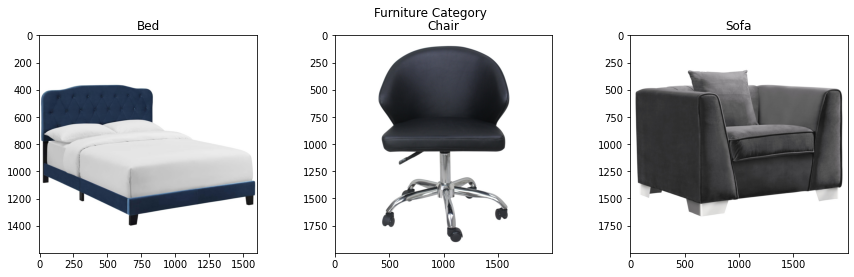

In [56]:
# Visualize sample image
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=len(furniture_label), figsize=(15,4))
fig.suptitle('Furniture Category')
for i,label in enumerate(furniture_label):
    ax[i].set_title(label)
    ax[i].imshow(plt.imread(df[df['label']==label]['img'].iloc[0]))

In [57]:
df['label'].value_counts()

Bed      100
Chair    100
Sofa     100
Name: label, dtype: int64

In [58]:
plt.imread(df['img'][0]).shape

(1600, 1600, 3)

In [59]:
# Encode label
df_labels = {
    'Bed' : 0,
    'Chair' : 1,
    'Sofa' : 2
}

df['encode_label'] = df['label'].map(df_labels)
df.head()

,img,label,encode_label
0,/content/drive/MyDrive/FulhausData/Bed/Amelia ...,Bed,0
1,/content/drive/MyDrive/FulhausData/Bed/Raina Q...,Bed,0
2,/content/drive/MyDrive/FulhausData/Bed/Bed Ven...,Bed,0
3,/content/drive/MyDrive/FulhausData/Bed/Amaris ...,Bed,0
4,/content/drive/MyDrive/FulhausData/Bed/Amaris ...,Bed,0


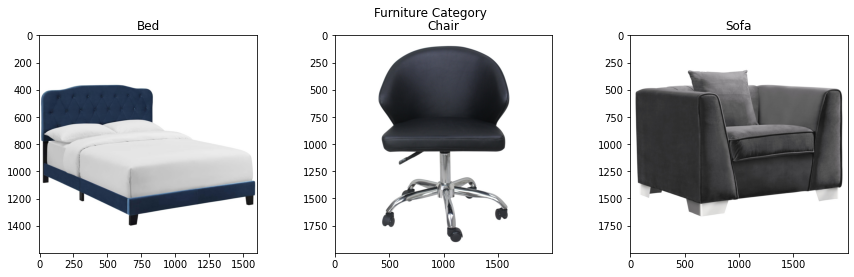

In [60]:
# Visualize sample image
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=len(furniture_label), figsize=(15,4))
fig.suptitle('Furniture Category')
for i,label in enumerate(furniture_label):
    ax[i].set_title(label)
    ax[i].imshow(plt.imread(df[df['label']==label]['img'].iloc[0]))

In [61]:
# Define image augmentation parameters
rotation_range = 20 
zoom_range = 0.1
horizontal_flip = True 

X = []

for img in df['img']:
    img = cv2.imread(str(img))
    rows,cols,channels = img.shape
    # augment_function(img)
    # random rotation 
    angle = np.random.uniform(-rotation_range, rotation_range)
    R = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img = cv2.warpAffine(img, R, (cols,rows))
    # random zoom (0.1)
    zoom = np.random.uniform(1-zoom_range, 1+zoom_range)
    pts1 = np.float32([[cols/2-rows/2*zoom,rows/2-rows/2*zoom],
                       [cols/2+rows/2*zoom,rows/2-rows/2*zoom],
                       [cols/2-rows/2*zoom,rows/2+rows/2*zoom]])
    pts2 = np.float32([[0,0],[cols,0],[0,rows]])
    Z = cv2.getAffineTransform(pts1,pts2)
    img = cv2.warpAffine(img, Z,(cols,rows))
    # random flip
    if horizontal_flip and np.random.random() < 0.5:
        img = cv2.flip(img, 1)
    # resize to 128 x 128 x 3
    img = cv2.resize(img, (128, 128))
    img = img/255
    X.append(img)

In [62]:
len(X)

300

In [64]:
y = df['encode_label']

# New Section

In [65]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [66]:

base_model = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet')

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [67]:
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


In [68]:
model = Sequential()
model.add(keras.Input(shape=(128,128,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(furniture_label), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16,812,867
Trainable params: 9,177,603
N

In [69]:
model.compile(
  optimizer="adam",
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])
history = model.fit(np.array(X_train), np.array(y_train), epochs=10, validation_data=(np.array(X_val), np.array(y_val)))

Epoch 1/20
8/8 [==============================] - 85s 10s/step - loss: 1.3735 - acc: 0.4311 - val_loss: 1.3672 - val_acc: 0.2632
Epoch 2/20
8/8 [==============================] - 69s 9s/step - loss: 0.9007 - acc: 0.5200 - val_loss: 0.6982 - val_acc: 0.6842
Epoch 3/20
8/8 [==============================] - 73s 9s/step - loss: 0.7342 - acc: 0.6400 - val_loss: 1.5916 - val_acc: 0.3158
Epoch 4/20
8/8 [==============================] - 79s 10s/step - loss: 0.8114 - acc: 0.5867 - val_loss: 0.7005 - val_acc: 0.5263
Epoch 5/20
8/8 [==============================] - 74s 9s/step - loss: 0.5731 - acc: 0.6622 - val_loss: 0.8171 - val_acc: 0.5263
Epoch 6/20
8/8 [==============================] - 75s 9s/step - loss: 0.5501 - acc: 0.6889 - val_loss: 0.4792 - val_acc: 0.7895
Epoch 7/20
8/8 [==============================] - 74s 9s/step - loss: 0.4249 - acc: 0.7778 - val_loss: 0.5201 - val_acc: 0.7368
Epoch 8/20
8/8 [==============================] - 68s 9s/step - loss: 0.4735 - acc: 0.7689 - val_loss:

In [70]:
model.evaluate(np.array(X_test),np.array(y_test))

2/2 [==============================] - 13s 5s/step - loss: 0.5983 - acc: 0.8571


[0.5983242988586426, 0.8571428656578064]

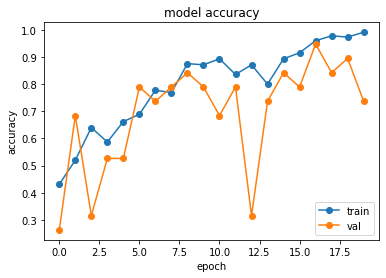

In [71]:
plt.plot(history.history['acc'], marker='o')
plt.plot(history.history['val_acc'], marker='o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


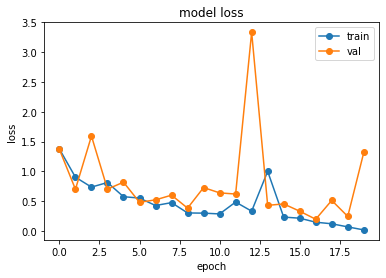

In [72]:
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [74]:
model.save('vgg16_model.h5')
